# Simple MNIST NN from scratch

In this notebook, I implemented a simple three-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

Here's a video I made explaining all the math and showing my progress as I coded the network: https://youtu.be/w8yWXqWQYmU

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [3]:
Y_train

array([7, 0, 9, ..., 9, 3, 6])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [22]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    W3 = np.random.rand(10, 10) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2, W3, b3

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2, dW3, db3
def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3

In [23]:
def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A3)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2, W3, b3

In [27]:
W1, b1, W2, b2, W3, b3 = gradient_descent(X_train, Y_train, 0.085, 500)

Iteration:  0
[8 4 5 ... 4 5 4] [7 0 9 ... 9 3 6]
0.08902439024390243
Iteration:  10
[8 4 5 ... 4 5 4] [7 0 9 ... 9 3 6]
0.11334146341463415
Iteration:  20
[7 0 5 ... 4 5 4] [7 0 9 ... 9 3 6]
0.159
Iteration:  30
[7 0 5 ... 4 5 4] [7 0 9 ... 9 3 6]
0.20202439024390245
Iteration:  40
[7 0 5 ... 7 5 4] [7 0 9 ... 9 3 6]
0.24160975609756097
Iteration:  50
[7 0 5 ... 2 5 4] [7 0 9 ... 9 3 6]
0.2728780487804878
Iteration:  60
[7 0 5 ... 2 5 4] [7 0 9 ... 9 3 6]
0.2975853658536585
Iteration:  70
[7 0 5 ... 2 5 4] [7 0 9 ... 9 3 6]
0.3219268292682927
Iteration:  80
[7 0 5 ... 2 5 4] [7 0 9 ... 9 3 6]
0.35178048780487803
Iteration:  90
[7 0 9 ... 7 5 4] [7 0 9 ... 9 3 6]
0.3825609756097561
Iteration:  100
[7 0 9 ... 7 5 6] [7 0 9 ... 9 3 6]
0.4117073170731707
Iteration:  110
[7 0 9 ... 7 5 6] [7 0 9 ... 9 3 6]
0.44258536585365854
Iteration:  120
[7 0 9 ... 7 5 6] [7 0 9 ... 9 3 6]
0.47397560975609754
Iteration:  130
[7 0 9 ... 7 5 2] [7 0 9 ... 9 3 6]
0.5044878048780488
Iteration:  140
[7 0 9 

~81.6% accuracy on training set.

In [31]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [3]
Label:  3


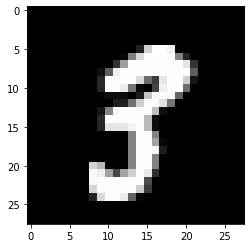

Prediction:  [7]
Label:  3


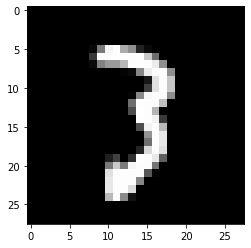

Prediction:  [2]
Label:  1


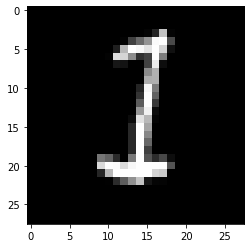

Prediction:  [5]
Label:  5


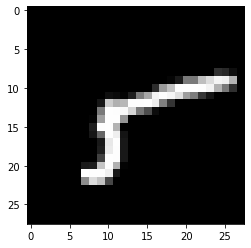

In [37]:
test_prediction(0, W1, b1, W2, b2, W3, b3)
test_prediction(1, W1, b1, W2, b2, W3, b3)
test_prediction(2, W1, b1, W2, b2, W3, b3)
test_prediction(3, W1, b1, W2, b2, W3, b3)

Finally, let's find the accuracy on the dev set:

In [33]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2, W3, b3)
get_accuracy(dev_predictions, Y_dev)

[9 8 3 9 1 1 8 0 8 4 9 9 1 5 8 5 6 7 6 4 9 8 8 7 7 3 6 3 5 3 1 9 1 6 5 3 6
 8 1 8 9 2 8 2 1 3 5 1 2 5 8 3 8 4 4 9 7 4 9 6 5 4 6 6 3 5 4 3 0 9 2 2 6 4
 0 4 4 4 5 9 0 4 0 4 4 8 7 6 2 0 7 0 5 9 9 4 1 7 9 7 9 5 3 2 6 4 2 3 7 2 5
 0 3 2 3 1 9 9 5 7 1 4 0 1 0 2 5 4 5 0 4 2 5 8 7 1 7 9 2 4 1 7 4 7 6 7 9 5
 1 1 3 0 0 7 4 7 3 2 7 1 6 3 1 6 2 7 8 9 3 4 5 5 6 7 4 1 1 1 7 7 9 6 9 1 4
 4 0 4 0 9 3 7 8 1 6 2 0 9 1 8 3 1 0 0 6 2 0 6 7 8 5 9 3 1 1 5 7 5 8 4 1 4
 1 3 8 3 1 5 3 8 3 0 9 6 2 0 1 9 2 6 4 3 2 2 7 1 4 0 4 7 6 3 9 0 8 6 7 1 9
 1 5 0 4 1 3 7 2 1 3 1 2 4 2 1 1 2 5 5 3 6 3 8 9 7 3 8 1 4 0 2 6 6 1 6 1 5
 3 4 8 7 2 3 2 9 7 5 0 5 4 2 4 9 7 9 2 8 9 4 3 8 1 6 8 2 3 2 9 4 1 1 8 7 4
 5 6 5 2 1 9 7 4 3 0 4 0 4 1 4 1 0 8 1 6 2 9 8 1 2 9 0 8 4 0 3 1 6 7 7 8 4
 4 7 3 2 6 7 1 4 4 2 5 8 5 8 2 4 3 8 3 1 0 0 3 4 0 7 1 5 8 4 7 8 1 1 6 4 0
 9 1 3 3 8 7 4 0 6 2 8 9 0 4 3 7 7 4 3 6 2 7 2 3 7 1 1 3 5 1 0 4 4 9 9 0 8
 1 4 9 3 6 7 5 1 2 0 4 0 0 9 4 2 8 7 6 1 4 9 8 7 4 2 5 8 7 3 8 2 3 9 4 5 7
 1 2 3 2 6 3 1 1 2 6 2 7 

0.829

Increased to 82.9% accuracy, so our model generalized from the training data pretty well.